In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
%matplotlib inline

## Data

The **demographics** dataset contains information related to the population statistics for each region.

#### Background research

To give clarity to the dataset, the definition of some attributes are listed below. Note that some atrributes are self-explanatory and are thus excluded.

**population_clustered** - population for regions of more than 1 million

**population_density** - population per squared kilometer of land area

**human_development_index** - measure of the region's social and economic development, associating life expectancy, education, and per capita income indicators

## Read data

#### Read .csv files

To prevent Pandas from recognizing the string "NA" (which represents the country Namibia) as a null value, set the argument *keep_default_na* to False and pass a list of values to be interpreted as null (which excludes "NA") to *na_values* when reading the CSV file.

In [55]:
#Exclude "NA" from list of na_values
na_values = ["","#N/A","#N/A N/A","#NA","-1.#IND","-1.#QNAN","-NaN","-nan","1.#IND","1.#QNAN","<NA>","N/A","NULL","NaN","n/a","nan","null"]

#Read csv
demographics = pd.read_csv('data/demographics.csv', keep_default_na=False, na_values=na_values)
demographics.head()

,location_key,population,population_male,population_female,population_rural,population_urban,population_largest_city,population_clustered,population_density,human_development_index,population_age_00_09,population_age_10_19,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older
0,AD,77265.0,58625.0,55581.0,9269.0,67873.0,NaN,NaN,164.394,0.858,9370.0,12022.0,10727.0,12394.0,21001.0,20720.0,14433.0,8657.0,4881.0
1,AE,9890400.0,6836349.0,3054051.0,1290785.0,8479744.0,2833079.0,5914068.0,118.306,0.863,1011713.0,842991.0,2149343.0,3169314.0,1608109.0,797913.0,242707.0,55884.0,12426.0
2,AF,38928341.0,19976265.0,18952076.0,28244481.0,9797273.0,4114030.0,4114030.0,59.627,0.498,11088732.0,9821559.0,7035871.0,4534646.0,2963459.0,1840198.0,1057496.0,480455.0,105925.0
3,AF_BAL,1509183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AF_BAM,495557.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Select data

**location_key** is a unique identifier for the country and subregions that can be used to merge all the datasets and correlate selected information from these datasets. 

Of the 19 columns in the **demographics** dataset, only the columns **location_key**, **population**, **population_density**, and **human_development_index** seem necessary for the analysis of COVID-related cases. The rest of the columns can be dropped from the dataset. 

In [56]:
demographics_attributes = ['location_key', 'population', 'population_density' ,'human_development_index']
demographics = demographics.loc[:,demographics_attributes]
demographics.head()

,location_key,population,population_density,human_development_index
0,AD,77265.0,164.394,0.858
1,AE,9890400.0,118.306,0.863
2,AF,38928341.0,59.627,0.498
3,AF_BAL,1509183.0,NaN,NaN
4,AF_BAM,495557.0,NaN,NaN


Only the **data per country** are necessary, therefore remove all rows for subregions, which are denoted by the locations with "_" under the **location_key** column:

In [57]:
demographics = demographics[demographics['location_key'].str.contains("_") == False].reset_index(drop=True)
demographics.head()

,location_key,population,population_density,human_development_index
0,AD,77265.0,164.394,0.858
1,AE,9890400.0,118.306,0.863
2,AF,38928341.0,59.627,0.498
3,AG,97928.0,222.564,0.780
4,AI,15002.0,166.689,NaN


## Prepare data

#### Check data types

The **location_key** column is an object while the three numeric columns of the **demographics** dataset are all floating point numbers. 

While the metadata indicates that **population** values are integers (and since population count is inherently an integer), its data type is still float64 due to the presence of null values in these columns. 

In [58]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location_key             246 non-null    object 
 1   population               245 non-null    float64
 2   population_density       230 non-null    float64
 3   human_development_index  186 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.8+ KB


Change the data type of **location_key** to string:

In [59]:
demographics = demographics.astype({'location_key':'string'})
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location_key             246 non-null    string 
 1   population               245 non-null    float64
 2   population_density       230 non-null    float64
 3   human_development_index  186 non-null    float64
dtypes: float64(3), string(1)
memory usage: 7.8 KB


#### Check unique values

Check that **location_key** column only has unique values for each row to ensure that no country is duplicated:

In [60]:
demographics['location_key'].is_unique

True

#### Check for missing values

All columns in the dataset except location_key have missing values:

In [61]:
demographics.isna().sum()

location_key                0
population                  1
population_density         16
human_development_index    60
dtype: int64

##### Check and handle missing values of population column

In [62]:
demographics[demographics['population'].isna()]

,location_key,population,population_density,human_development_index
196,SJ,NaN,NaN,NaN


SJ (Svalbard and Jan Mayen) does not have a permanent human population, therefore retain the current information.

##### Check and handle missing values of population_density column

In [63]:
demographics[demographics['population_density'].isna()]

,location_key,population,population_density,human_development_index
7,AN,197041.0,NaN,NaN
9,AQ,4400.0,NaN,NaN
32,BV,0.0,NaN,NaN
37,CC,596.0,NaN,NaN
52,CX,1843.0,NaN,NaN
79,GG,63276.0,NaN,NaN
87,GS,30.0,NaN,NaN
93,HM,0.0,NaN,NaN
103,IO,4000.0,NaN,NaN
108,JE,105500.0,NaN,NaN


From research, the population densities of some of the countries with missing values are listed in the following dictionary. The rest of the countries in the list are either dissolved or have no permanent human population, therefore they are excluded from the dictionary and NaN values are retained.

In [70]:
#Define a dictionary for population densities of select countries
pop_density = {'CC':41.97, 'CX':13.65, 'GG':1020.58, 'JE':882.11, 'NF':63.24, 'PN':1.06, 'UM':3.86, 'XK':172.96}

Populate select countries in the dataset with their corresponding population densities:

In [68]:
demographics['population_density'].fillna(demographics['location_key'].map(pop_density), inplace=True)
demographics.iloc[[37,52,79,108,159,176,227,240]]

,location_key,population,population_density,human_development_index
37,CC,596.0,41.97,NaN
52,CX,1843.0,13.65,NaN
79,GG,63276.0,1020.58,NaN
108,JE,105500.0,882.11,NaN
159,NF,2188.0,63.24,NaN
176,PN,50.0,1.06,NaN
227,UM,190.0,3.86,NaN
240,XK,1883018.0,172.96,NaN


##### Check and handle missing values of human_development_index column

In [26]:
demographics[demographics['human_development_index'].isna()]

,location_key,population,population_density,human_development_index
4,AI,15002.0,166.689,NaN
7,AN,197041.0,NaN,NaN
9,AQ,4400.0,NaN,NaN
11,AS,55197.0,275.985,NaN
14,AW,106766.0,593.144,NaN
25,BM,62273.0,1245.460,NaN
28,BQ,26221.0,79.942,NaN
32,BV,0.0,NaN,NaN
37,CC,596.0,NaN,NaN
43,CK,17564.0,73.183,NaN


From research, the human development indices of some of the countries with missing values are listed in the following dictionary. The rest of the countries in the list are either dissolved or have no permanent human population, therefore they are excluded from the dictionary and NaN values are retained.

In [80]:
#Define a dictionary for human development indices of select countries
country = ['AS','AW','BM','CK','FK','FM','FO','GE','GF','GG','GI','GU','IE','IM','JE','KP','KY','MC','MK','MO',\
           'MP','MQ','MS','NF','NR','NU','PR','PS','RE','SH','SM','SO','SX','TC','TK','TV','VG','VI','WF','XK','YT']
hdi = [0.827,0.908,0.981,0.829,0.933,0.628,0.950,0.812,0.793,0.985,0.961,0.901,0.945,0.849,0.985,0.733,0.877,0.956,0.770,0.909,\
        0.875,0.848,0.821,0.958,0.721,0.794,0.845,0.690,0.843,0.797,0.853,0.364,0.702,0.873,0.750,0.641,0.945,0.894,0.763,0.787,0.781]
hdi_country = dict(zip(country,hdi))
print(hdi_country)

{'AS': 0.827, 'AW': 0.908, 'BM': 0.981, 'CK': 0.829, 'FK': 0.933, 'FM': 0.628, 'FO': 0.95, 'GE': 0.812, 'GF': 0.793, 'GG': 0.985, 'GI': 0.961, 'GU': 0.901, 'IE': 0.945, 'IM': 0.849, 'JE': 0.985, 'KP': 0.733, 'KY': 0.877, 'MC': 0.956, 'MK': 0.77, 'MO': 0.909, 'MP': 0.875, 'MQ': 0.848, 'MS': 0.821, 'NF': 0.958, 'NR': 0.721, 'NU': 0.794, 'PR': 0.845, 'PS': 0.69, 'RE': 0.843, 'SH': 0.797, 'SM': 0.853, 'SO': 0.364, 'SX': 0.702, 'TC': 0.873, 'TK': 0.75, 'TV': 0.641, 'VG': 0.945, 'VI': 0.894, 'WF': 0.763, 'XK': 0.787, 'YT': 0.781}


Populate select countries in the dataset with their corresponding human development indices:

In [81]:
demographics['human_development_index'].fillna(demographics['location_key'].map(hdi_country), inplace=True)
demographics.iloc[[4,7,9,11,14]] #check first 5 countries in dictionary

,location_key,population,population_density,human_development_index
4,AI,15002.0,166.689,NaN
7,AN,197041.0,NaN,NaN
9,AQ,4400.0,NaN,NaN
11,AS,55197.0,275.985,0.827
14,AW,106766.0,593.144,0.908


#### Check for outliers and out-of-range values

The descriptive statistics, including the central tendency, dispersion and shape of a dataset’s distribution, are shown below. 

In [83]:
demographics.describe().applymap("{0:.2f}".format)

,population,population_density,human_development_index
count,245.00,238.00,227.00
mean,31676743.00,468.90,0.73
std,132430008.98,2320.20,0.15
min,0.00,0.14,0.35
25%,285491.00,35.38,0.62
50%,5057677.00,91.81,0.75
75%,19129955.00,233.26,0.85
max,1439323774.00,26338.26,0.98


Use a boxplot to detect outliers in the dataset:

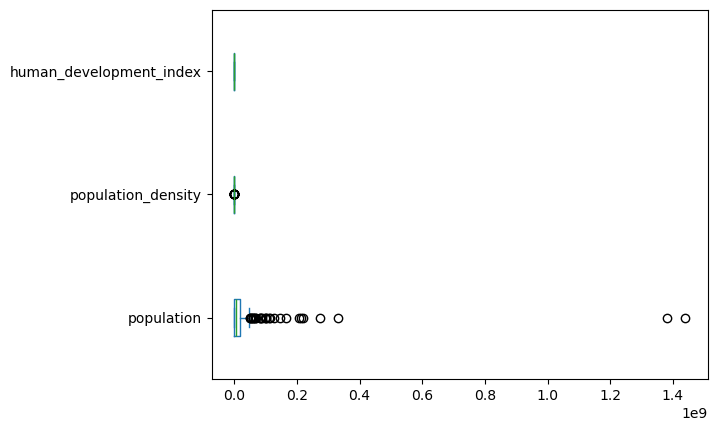

In [84]:
demographics.plot.box(vert=False)
plt.show()

The **population** column seem to have two outliers, but these data are for the two most populous countries in the world, China and India, whose population are both in the billion people range.

In [85]:
demographics[(demographics['population'] > 1.2e9)]

,location_key,population,population_density,human_development_index
46,CN,1.439324e+09,153.312,0.752
102,IN,1.380004e+09,464.149,0.640
